In [89]:
import pymc3 as pm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import arviz as az
import requests
from datetime import datetime as dt

In [90]:
url = 'https://brasil.io/dataset/covid19/caso?format=csv'
#dfcov = pd.read_csv('covid19-2503.csv')
dfcov = pd.read_csv(url)
dfcov.date = pd.to_datetime(dfcov.date, format = '%Y-%m-%d')
dfcov.date = dfcov.date.apply(lambda d: dt.date(d))
dfuf = dfcov.loc[(dfcov.place_type == 'state')]
dfuf = dfuf.sort_values(by = ['state', 'date'])

In [91]:
def reindex_by_date(df):
    dates = pd.date_range(dfcov.date.min(), dfcov.date.max())
    return df.reindex(dates).bfill().ffill()

dfuf = dfuf.set_index('date').groupby('state').apply(reindex_by_date).reset_index(0, drop=True)
dfuf = dfuf.reset_index().rename({'index' :'date'}, axis = 1)

In [92]:
dfuf['dif'] = dfuf.reset_index().groupby('state').confirmed.diff(periods = 1).fillna(0)

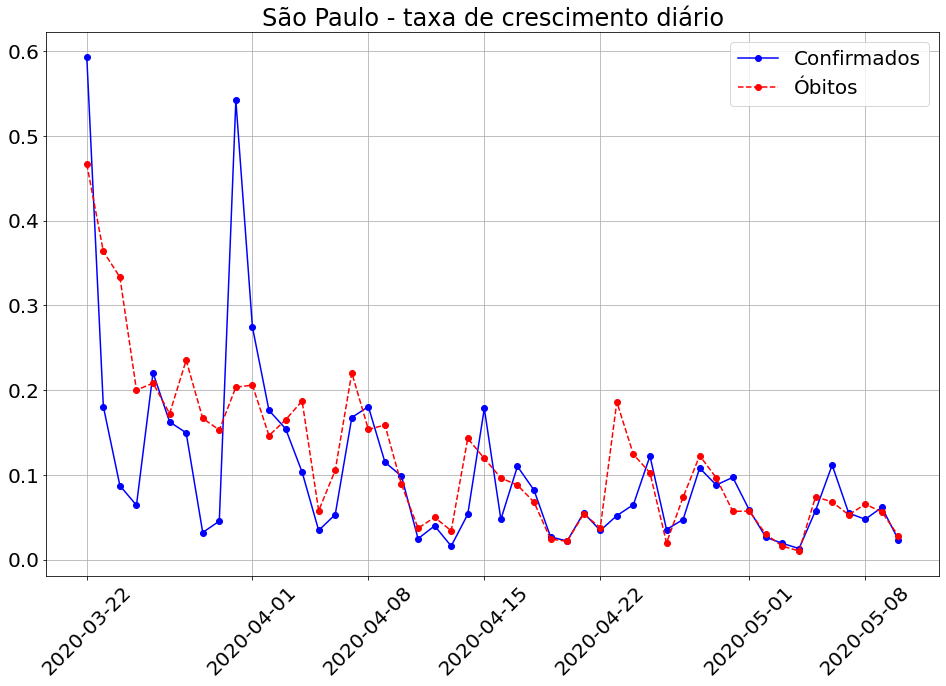

In [100]:
dfsp = dfuf.loc[dfuf.state == 'SP'].copy()
dfsp = dfsp.set_index('date')
#dfsp.loc['2020-04-02', 'confirmed'] = 3506
#dfsp.loc['2020-04-02', 'deaths'] = 208
dfsp['growth'] = dfsp.confirmed.pct_change()
dfsp['growthd'] = dfsp.deaths.pct_change()

dftmp = dfsp.loc[(dfsp.index > '2020-03-21')] #& (dfsp.index <= '2020-04-23')]
#dfsp = dfsp.loc[ (dfsp.index <= '2020-04-16')]

fig = plt.figure(figsize = (16,10))
plt.rcParams.update({'font.size' : 20})
plt.plot(dftmp.growth, 'bo-', label = 'Confirmados')
plt.plot(dftmp.growthd, 'ro--', label = 'Óbitos')
plt.xticks(rotation = 45)
plt.title("São Paulo - taxa de crescimento diário", fontsize = 24)
#plt.ylim(0, .5)
plt.legend()
plt.grid(True)

In [94]:
# Convertendo pra doubling time
dfsp['doubling'] = np.log(2) / np.log(1+dfsp['growth'])
dfsp['doublingd'] = np.log(2) / np.log(1+dfsp['growthd'])

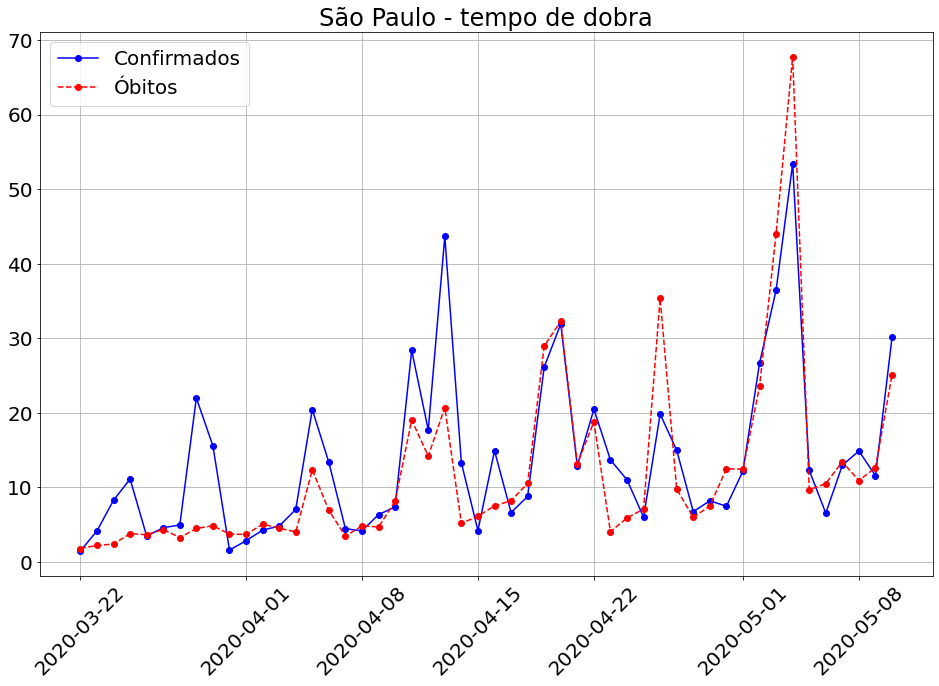

In [95]:
dftmp = dfsp.loc[(dfsp.index > '2020-03-21')]# & (dfsp.index <= '2020-04-19')]

fig = plt.figure(figsize = (16,10))
plt.rcParams.update({'font.size' : 20})
plt.plot(dftmp.doubling, 'bo-', label = 'Confirmados')
plt.plot(dftmp.doublingd, 'ro--', label = 'Óbitos')
plt.xticks(rotation = 45)
plt.title("São Paulo - tempo de dobra", fontsize = 24)
#plt.ylim(0, .5)
plt.legend()
plt.grid(True)

Série histórica - confirmados no Brasil x crescimento médio 33%

In [96]:
dftotal = dfuf.groupby('date').agg({'confirmed' : 'sum', 'deaths' : 'sum'}).reset_index()
dftotal = dftotal.sort_values('date', ascending = True)
dftotal = dftotal.set_index('date')

dftotal['growth'] = dftotal.confirmed.pct_change()
dftotal['growthd'] = dftotal.deaths.pct_change()

dftotal['newcases'] = dftotal.confirmed.diff(1)
dftotal['newdeaths'] = dftotal.deaths.diff(1)

dftotal['doubling'] = np.log(2) / np.log(1+dftotal['growth'])
dftotal['doublingd'] = np.log(2) / np.log(1+dftotal['growthd'])

In [97]:
dftotal

,confirmed,deaths,growth,growthd,newcases,newdeaths,doubling,doublingd
date,,,,,,,,
2020-02-25,50.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-26,50.0,0.0,0.000000,NaN,0.0,0.0,inf,NaN
2020-02-27,50.0,0.0,0.000000,NaN,0.0,0.0,inf,NaN
2020-02-28,51.0,0.0,0.020000,NaN,1.0,0.0,35.002789,NaN
2020-02-29,51.0,0.0,0.000000,NaN,0.0,0.0,inf,NaN
2020-03-01,51.0,0.0,0.000000,NaN,0.0,0.0,inf,NaN
2020-03-02,51.0,0.0,0.000000,NaN,0.0,0.0,inf,NaN
2020-03-03,51.0,0.0,0.000000,NaN,0.0,0.0,inf,NaN
2020-03-04,52.0,0.0,0.019608,NaN,1.0,0.0,35.695958,NaN


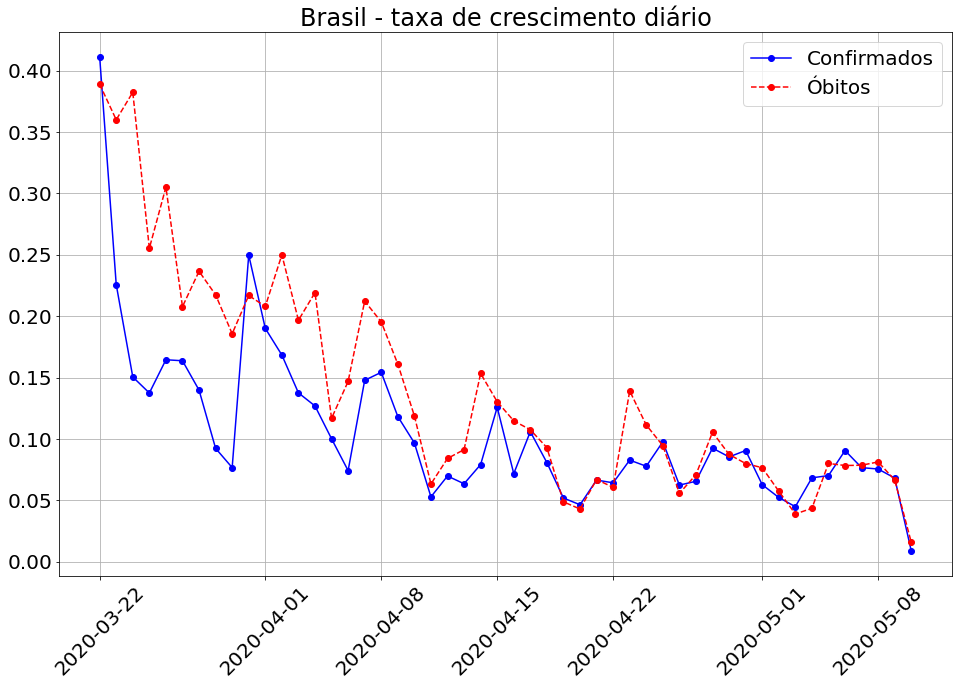

In [99]:
dftmp = dftotal.loc[(dftotal.index > '2020-03-21')]# & (dftotal.index <= '2020-05-04')]
#dfsp = dfsp.loc[ (dfsp.index <= '2020-04-16')]

fig = plt.figure(figsize = (16,10))
plt.rcParams.update({'font.size' : 20})
plt.plot(dftmp.growth, 'bo-', label = 'Confirmados')
plt.plot(dftmp.growthd, 'ro--', label = 'Óbitos')
plt.xticks(rotation = 45)
plt.title("Brasil - taxa de crescimento diário", fontsize = 24)
#plt.ylim(0, .5)
plt.legend()
plt.grid(True)


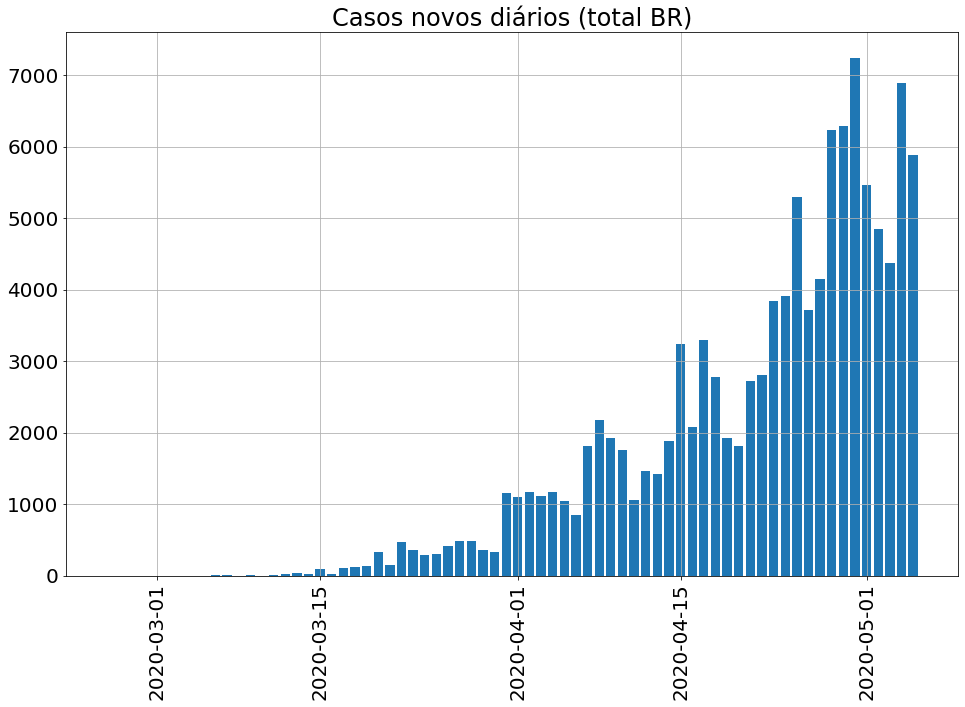

In [88]:
fig = plt.figure(figsize = (16, 10))

plt.bar(x = dftotal.index, height = dftotal.confirmed.diff(periods = 1))
plt.grid(True)
plt.xticks(rotation = 90)
plt.title("Casos novos diários (total BR)")
plt.show()

# Modelo por município

In [49]:
# Lendo lat long
dfgeo = pd.read_csv('municipios.csv')

In [76]:
dfmun = dfcov[(dfcov.place_type == 'city')]

In [77]:
dfmun = dfmun.loc[(~dfmun.city_ibge_code.isna())]

In [78]:
dfmun['city_ibge_code'] = dfmun.city_ibge_code.apply(lambda l: int(l))

In [79]:
dfmun = dfmun.merge(dfgeo[['codigo_ibge', 'latitude', 'longitude']], left_on = 'city_ibge_code', right_on = 'codigo_ibge', how = 'left')

In [84]:
from geopy import distance

In [102]:
from itertools import combinations
from tqdm import tqdm

i = 0
dist = []
for c in tqdm(combinations(dfmun.city_ibge_code.unique(), 2)):
    lat1, long1 = dfmun.loc[(dfmun.city_ibge_code == c[0]), ['latitude', 'longitude']].values[0]
    lat2, long2 = dfmun.loc[(dfmun.city_ibge_code == c[1]), ['latitude', 'longitude']].values[0]
    dist.append([c[0], c[1], distance.distance((lat1, long1), (lat2, long2))])
    

20503it [02:42, 127.76it/s]


In [103]:
dfdist = pd.DataFrame({'cod1' : [c[0] for c in dist], 'cod2' : [c[1] for c in dist], 'd' : [c[2] for c in dist]})
dfdist.to_csv('dist.csv', index = False)

In [104]:
dfdist

,cod1,cod2,d
0,1200401,2704302,3518.945021266715 km
1,1200401,2707503,3395.3005902876666 km
2,1200401,1302603,1148.3828643372065 km
3,1200401,1303403,1470.8928061489853 km
4,1200401,2903201,2504.993617485891 km
5,1200401,2904605,2883.7088016905755 km
6,1200401,2905701,3232.3746994815347 km
7,1200401,2906204,2854.555313420211 km
8,1200401,2908507,3182.91814783917 km
9,1200401,2908606,3307.5798684496062 km
